# Marketing project

**The goal**:
- Analyse the marketing to see whether advertising pays off
- Understand which devices, countries, and advertising channels can negatively impact ads ROI
- Investigate what can cause payback problems
- Explore conversion and retention by device, country, advertising channel

**Input data**: 
- We are marketing analysts for the entertainment app Procrastinate Pro+
- For new users who registered in the period from 2019-05-01 to 2019-10-27 we have server log data with:
    - Visits
    - Purchases 
    - Advertising costs
- The date of analysis: 2019-11-01
- It is generally accepted that payback should occur no later than **2 weeks** after user acquisition

**Analysis structure**:
* Data overview
* Creating functions to calculate main metrics
* EDA
* Marketing analysis
* Return on advertising
* Results
* Recommendation to the marketing team

## Data overview

In [50]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [51]:
# set floats formats (in order not to see scientific notation)

pd.options.display.float_format = '{:.2f}'.format

In [52]:
# upload data

try:
    sessions = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    ad_costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    sessions = pd.read_csv('visits_info_short.csv')
    orders = pd.read_csv('orders_info_short.csv')
    ad_costs = pd.read_csv('costs_info_short.csv')

In [53]:
sessions.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [54]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [55]:
# rename column names

sessions.columns = sessions.columns.str.lower()
sessions = sessions.rename(columns={
                                    'user id': 'user_id',
                                    'session start': 'session_start',
                                    'session end': 'session_end'
                                    }
                          )

In [56]:
# change data types for dates

sessions['session_start'] = pd.to_datetime(sessions['session_start'])
sessions['session_end'] = pd.to_datetime(sessions['session_end'])

In [57]:
sessions.sample(10)

,user_id,region,device,channel,session_start,session_end
32994,926903786857,United States,iPhone,FaceBoom,2019-06-03 15:05:34,2019-06-03 15:30:02
255455,526079213033,France,Android,OppleCreativeMedia,2019-08-04 13:28:37,2019-08-04 13:44:11
45002,275917132524,United States,Android,TipTop,2019-06-17 00:28:18,2019-06-17 00:32:59
54282,38248632247,United States,iPhone,FaceBoom,2019-06-26 17:57:36,2019-06-26 18:02:19
87760,38686066143,United States,PC,organic,2019-07-27 19:31:57,2019-07-27 19:59:51
46945,659846001416,United States,Android,organic,2019-06-19 00:09:52,2019-06-19 00:44:18
164518,596363673878,United States,Android,TipTop,2019-09-29 03:30:33,2019-09-29 03:59:43
267277,736332601829,Germany,PC,LeapBob,2019-08-24 02:24:25,2019-08-24 02:43:58
171651,831270870141,United States,iPhone,FaceBoom,2019-10-03 15:11:41,2019-10-03 15:18:19
191005,482618955635,United States,iPhone,FaceBoom,2019-10-17 11:37:00,2019-10-17 11:39:27


In [58]:
# check for full duplicates

sessions.duplicated().sum()

0

In [59]:
sessions['user_id'].nunique()

150008

In [60]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [61]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [62]:
# rename column names

orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={
                                    'user id': 'user_id',
                                    'event dt': 'event_dt'
                                }
                          )

In [63]:
# change data types for dates

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [64]:
orders.sample(10)

,user_id,event_dt,revenue
23871,160430598948,2019-10-12 00:04:11,4.99
37623,655749790269,2019-10-06 03:38:43,4.99
39058,75914663007,2019-10-20 17:33:37,49.99
6263,339970102255,2019-07-05 22:21:19,4.99
4596,255737660014,2019-06-23 12:20:46,4.99
29658,497957399398,2019-06-20 14:58:09,4.99
15652,816194476669,2019-09-01 04:37:38,4.99
37081,428742740625,2019-09-30 01:18:00,4.99
12883,850640837379,2019-08-17 15:11:37,4.99
22974,121891069706,2019-10-08 20:23:15,4.99


In [65]:
# check for full duplicates

orders.duplicated().sum()

0

In [66]:
ad_costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.30
1,2019-05-02,FaceBoom,78.10
2,2019-05-03,FaceBoom,85.80
3,2019-05-04,FaceBoom,136.40
4,2019-05-05,FaceBoom,122.10


In [67]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [68]:
# rename column names

ad_costs.columns = ad_costs.columns.str.lower()

In [69]:
# change data types for dates

ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])

In [70]:
ad_costs.sample(10)

,dt,channel,costs
746,2019-05-27,YRabbit,10.20
198,2019-05-19,MediaTornado,8.64
894,2019-10-22,YRabbit,5.94
1581,2019-09-19,WahooNetBanner,31.20
756,2019-06-06,YRabbit,4.20
814,2019-08-03,YRabbit,4.83
895,2019-10-23,YRabbit,6.48
579,2019-06-09,TipTop,178.60
333,2019-10-01,MediaTornado,6.00
608,2019-07-08,TipTop,265.20


In [71]:
# check for full duplicates

ad_costs.duplicated().sum()

0

## Creating functions to calculate main metrics

### Profiles

In [72]:
# creating user profiles

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # find first sessions
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # for cohort analysis we determine the date and the month of the first session
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # determine whether the user is paying one
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # add events flags from event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # calc unique users from the same channel and date of acquisition
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # merge ad_costs
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # calc cac
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # add cac to the profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # for organic users the cac is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

### Retention

In [73]:
# calc retention

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # get payer as default for dimensions
    dimensions = ['payer'] + dimensions

    # drop users who didn't live full analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # collect raw data for the retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # groupping by dimensions
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # retention in time
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # return raw, retention table, and retention in time
    return result_raw, result_grouped, result_in_time

### Conversion

In [74]:
# calc conversion

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # drop users who didn't live full analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # determine first date of purchase
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # add purchases data to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # calc lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # groupping by cohort if dimensions is empty
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # groupping by dimensions
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # get convertion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # get conversion table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # drop 'cohort' from dimensions for conversion table in time
    if 'cohort' in dimensions: 
        dimensions = []

    # get conversion table in time
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

### LTV and ROI

In [75]:
# calc LTV and ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # drop users who didn't live full analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # add purchases data to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # calc lifetime for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # group by cohort if dimensions are empty
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # groupping by dimensions
    def group_by_dimensions(df, dims, horizon_days):
        
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # cumulative revenue
        result = result.fillna(0).cumsum(axis=1)
        # calc sizes of cohorts
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # merge revenue table and cohort sizes
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # calc LTV
        result = result.div(result['cohort_size'], axis=0)
        # drop all lifetimes bigger than horizon of analysis
        result = result[['cohort_size'] + list(range(horizon_days))]
        # get back cohort sizes
        result['cohort_size'] = cohort_sizes

        # get df with users data and cac, adding dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # calc mean CAC by dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # calc ROI
        roi = result.div(cac['cac'], axis=0)

        # kill infinite ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # get back cohort sizes ROI
        roi['cohort_size'] = cohort_sizes

        # add CAC to ROI table
        roi['cac'] = cac['cac']

        # leave cohorts, CAC, and ROI not longer than horizon of analysis
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    # get LTV and ROI tables
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # drop 'cohort' from dimensions for in time table
    if 'cohort' in dimensions:
        dimensions = []

    # get LTV and ROI tables in time
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  
        result_grouped,  
        result_in_time,
        roi_grouped,  
        roi_in_time,
    )

### Plotting functions

In [76]:
# rolling data

def filter_data(df, window):
    # for each column get rolling mean
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [77]:
# plotting retention

def plot_retention(retention, retention_history, horizon, window=7):

    # figsize
    plt.figure(figsize=(15, 10))

    # drop cohort sizes and retention in first day
    retention = retention.drop(columns=['cohort_size', 0])
    # in retention in time table leave only analysis horizon
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # if in table indexes there is only 'payer', add 'cohort'
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # 2 columns, 2 rows
    # in the first plot get retention for payers
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of paying users')

    # in the second plot get retention for non payers
    # share the vertical axis
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention of non-paying users')

    # in the third plot get retention of paying users in time
    ax3 = plt.subplot(2, 2, 3)
    # get columns names
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # filter and plot
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of acquisition')
    plt.title(
        'Retention of paying users on {} day'.format(
            horizon
        )
    )

    # in the fourth plot get retention of non paying users in time
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter and plot
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of acquisition')
    plt.title(
        'Retention of non paying users on {} day'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [78]:
# plotting conversion

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # figsize
    plt.figure(figsize=(15, 5))

    # drop cohort sizes
    conversion = conversion.drop(columns=['cohort_size'])
    # leave only analysis horizon for conversion in time
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # first plot - conversion
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Conversion')

    # second plot - conversion in time
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('Conversion on {} day'.format(horizon))

    plt.tight_layout()
    plt.show()

In [79]:
# plotting LTV and ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # figsize
    plt.figure(figsize=(20, 10))

    # drop cohort sizes
    ltv = ltv.drop(columns=['cohort_size'])
    # leave only analysis horizon for ltv in time
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # get separate df for CAC
    cac_history = roi_history[['cac']]

    # drop cohort size and CAC from ROI table
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # leave only analysis horizon for ROI in time
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # first plot - LTV
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('LTV')

    # second plot - LTV in time
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('LTV on {} day'.format(horizon))

    # third plot - CAC in time
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of acquisition')
    plt.title('CAC in time')

    # fourth plot - ROI
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    # fifth plot - ROI in time
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Payback level')
    plt.xlabel('Date of acquisition')
    plt.title('ROI on {} day'.format(horizon))

    plt.tight_layout()
    plt.show()

## EDA

### Profiles

In [80]:
# creating users profiles

ad_costs['dt'] = pd.to_datetime(ad_costs['dt']).dt.date
events = []
profiles = get_profiles(sessions, orders, events, ad_costs)

In [81]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.09
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.11
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.00
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.99
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.23


In [82]:
profiles.shape

(150008, 9)

In [83]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()

print(f'First date of user acquisition is {min_date}')
print(f'Last date of user acquisition is {max_date}')

First date of user acquisition is 2019-05-01
Last date of user acquisition is 2019-10-27


### Countries

In [84]:
# groupping by country

countries = profiles.groupby('region').agg({
                                            'user_id' : 'nunique',
                                            'payer' : 'sum'
                                           })

In [85]:
countries['proportion_of_payers'] = countries['payer'] / countries['user_id'] * 100

In [86]:
countries.sort_values(by='proportion_of_payers', ascending=False)

,user_id,payer,proportion_of_payers
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


The highest number of unique users are coming from **the US**.  

United States also has the highest proportion of paying users: **around 7%**.

### Devices

In [87]:
# groupping by device

devices = profiles.groupby('device').agg({
                                            'user_id' : 'nunique',
                                            'payer' : 'sum'
                                           })

In [88]:
devices['proportion_of_payers'] = devices['payer'] / devices['user_id'] * 100

In [89]:
devices.sort_values(by='proportion_of_payers', ascending=False)

,user_id,payer,proportion_of_payers
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


The highest number of unique users are using **iPhones**, where although the proportion of paying users is not the highest one.  
The highest one is among **Mac** users: **6,36%**.

### Channels

In [90]:
# groupping by device

channels = profiles.groupby('channel').agg({
                                            'user_id' : 'nunique',
                                            'payer' : 'sum'
                                           })

In [91]:
channels['proportion_of_payers'] = channels['payer'] / channels['user_id'] * 100

In [92]:
channels.sort_values(by='proportion_of_payers', ascending=False)

,user_id,payer,proportion_of_payers
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
...,...,...,...
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


The highest proportions of paying users are coming from **FaceBoom, AdNonSense, and lambdaMediaAds** channels: around 12%, 11%, and 10%, respectively.  

Organic source, not surprisingly, has the **lowest** proportion of payers with a bit more than **2%**.

## Marketing analysis

In [93]:
# total marketing costs

total_marketing_costs = round(ad_costs['costs'].sum())
print(f'Total marketing costs are {total_marketing_costs}')

Total marketing costs are 105497


In [94]:
# breakdown of marketing costs by channels

channels_costs = ad_costs.groupby('channel')['costs'].agg(['count', 'sum', 'mean']).sort_values(by='sum', ascending=False)
channels_costs['weight_in_total_costs'] = channels_costs['sum'] / total_marketing_costs
channels_costs

,count,sum,mean,weight_in_total_costs
channel,,,,
TipTop,180,54751.30,304.17,0.52
FaceBoom,180,32445.60,180.25,0.31
WahooNetBanner,180,5151.00,28.62,0.05
AdNonSense,180,3911.25,21.73,0.04
OppleCreativeMedia,180,2151.25,11.95,0.02
RocketSuperAds,180,1833.00,10.18,0.02
LeapBob,180,1797.60,9.99,0.02
lambdaMediaAds,180,1557.60,8.65,0.01
MediaTornado,180,954.48,5.30,0.01


- The amount of campaigns across different channels is the same
- Although the costs on each channel are not distributed uniformly: **TipTop and FaceBoom** channels got the biggest portions of total marketing costs (52% and 31%, respectively)

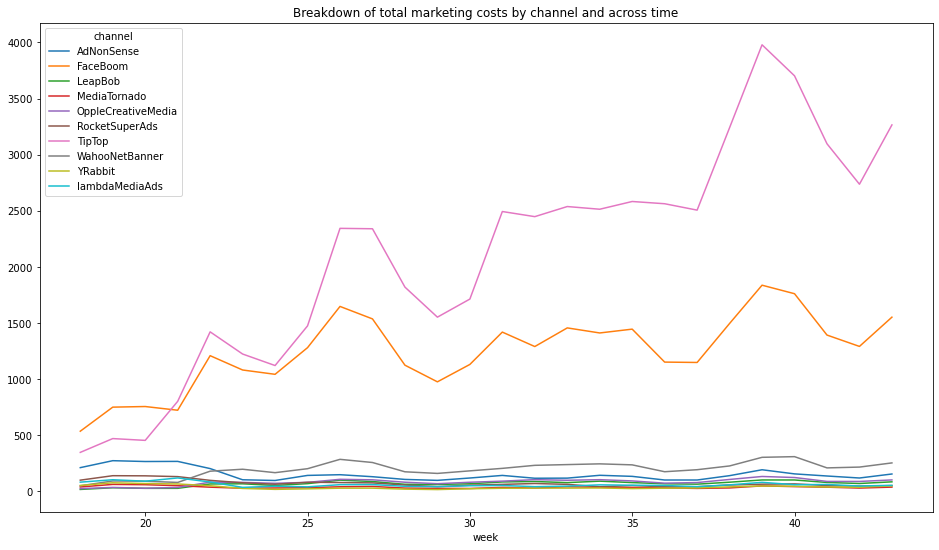

In [96]:
# breakdown of marketing costs by channels and across time

ad_costs['dt'] = pd.to_datetime(ad_costs['dt'])
ad_costs['week'] = ad_costs['dt'].dt.isocalendar().week

(
    ad_costs
    .pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
    .plot(figsize=(16,9), title='Breakdown of total marketing costs by channel and across time')
)
plt.show()

- Across time **TipTop and FaceBoom** channels were the biggest platforms  
- All other channels are **negligable** in comparison to top-2 ones
- For top-2 ones there is clear acceleration of week spendings (especially for **TipTop**) 

In [97]:
# filter out non organic users in order not to drag mean cac and roi down

profiles = profiles.query('channel != "organic"')

In [98]:
# mean cac total and across platforms

mean_cac = round(profiles['acquisition_cost'].mean(), 3)
mean_cac_channels = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
display(mean_cac_channels)

print(f'The average customer acqusition cost is {mean_cac}')

channel
TipTop               2.80
FaceBoom             1.11
AdNonSense           1.01
lambdaMediaAds       0.72
WahooNetBanner       0.60
RocketSuperAds       0.41
OppleCreativeMedia   0.25
YRabbit              0.22
MediaTornado         0.22
LeapBob              0.21
Name: acquisition_cost, dtype: float64

The average customer acqusition cost is 1.127


Channels where the mean cac is higher than the total mean cac is only **TipTop**

## Return on advertising

In [99]:
# setting observation date and horizon of analysis

observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Total

In [100]:
# get LTV and ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

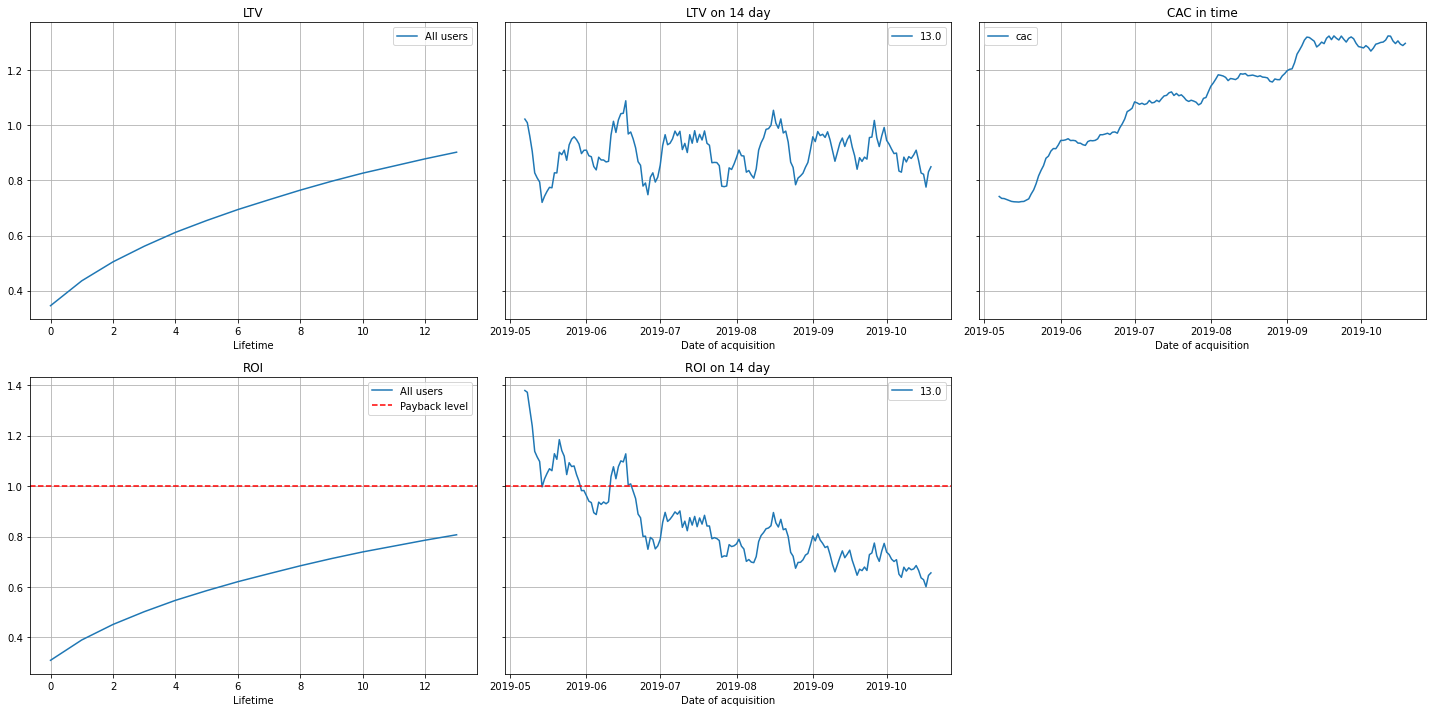

In [101]:
# plot LTV, ROI, and CAC

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- LTV curve looks okay
- LTV on the last day of the analysis horizon was keeping stable within the channel between 0,8 and 1,0
- CAC in time skyrocketed in the middle of May and kept on rising further on
- We suppose this was due to the growth of marketing costs on TipTop and FaceBoom platforms, but we see it later on in detail
- Due to such a sharp rise in CAC, the overall ROI have not reached the payback period
- Although in the beginning ROI was holding well

### Channels

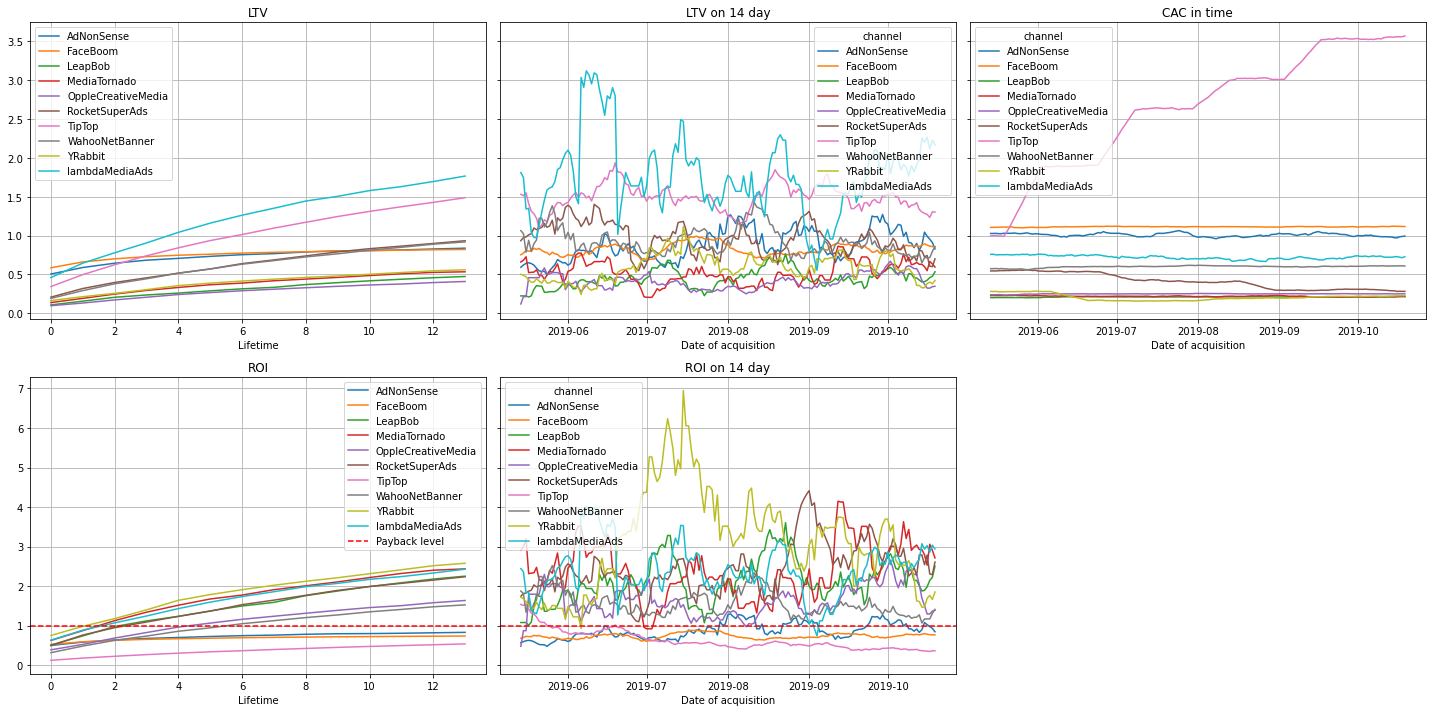

In [102]:
# have a deeper view across channels

dimensions = ['channel']

# get LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# plot LTV, ROI, and CAC
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- With the help of breakdown by channels, we see that the advertising on **TipTop, FaceBoom, and AdNonSense** platforms is not paying back
- The channels with highest ROI are: **YRabbit, MediaTornado, and lambdaMediaAds**
- As supposed in the previous point, CAC on TipTop grew significantly over time, while LTV didn't catch up
- CAC on all other platforms was pretty stable, and **even dropping on RocketSuperAds**

### Countries

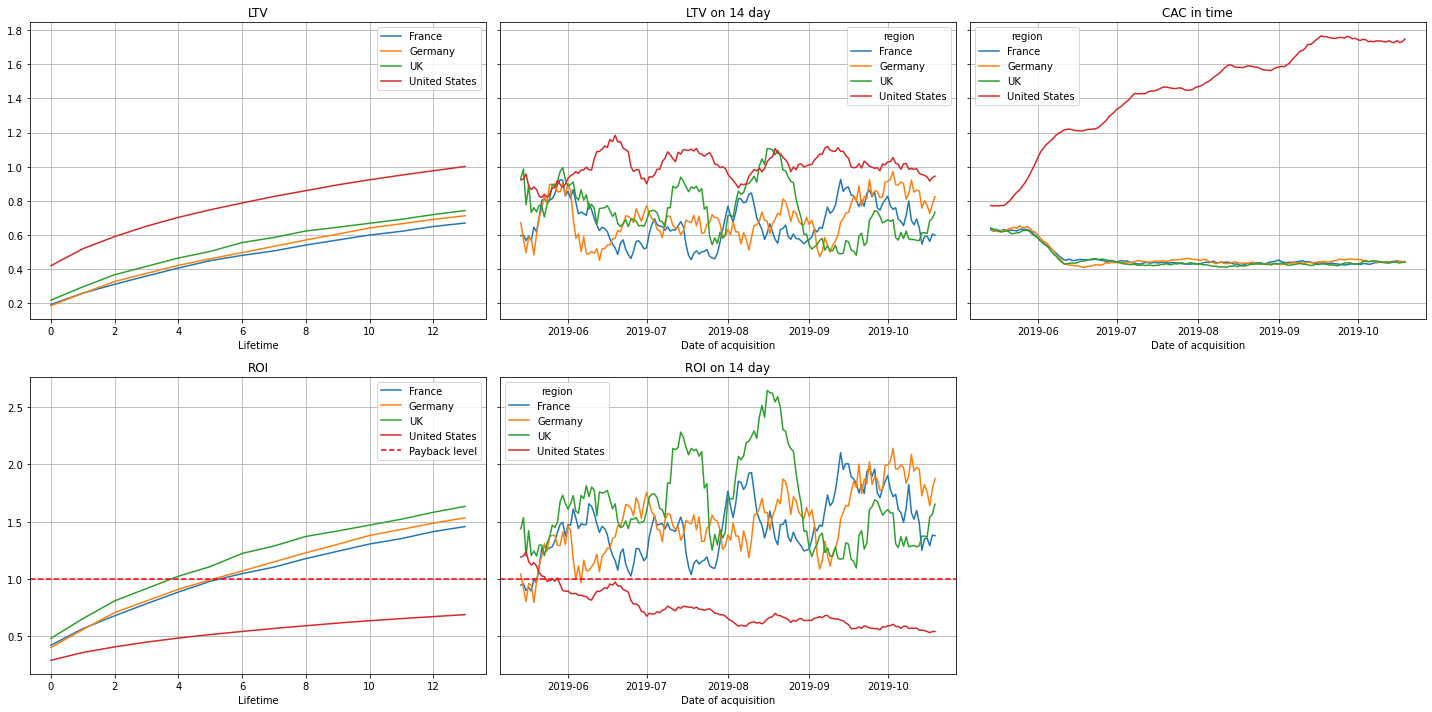

In [103]:
# have a deeper view across regions

dimensions = ['region']

# get LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# plot LTV, ROI, and CAC
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- With the help of breakdown by countries, we see that the **advertising in the US is not paying back**
- Although, the **LTV is the highest in the US**, it doesn't catch up with the growth of CAC there
- The CAC dynamics in the US follow the curve of total CAC in time and CAC on TipTop platform, most probably meaning that the **advertising in the US on TipTop plarform is responsible for the overall non profitability of marketing for the company** 

### Devices

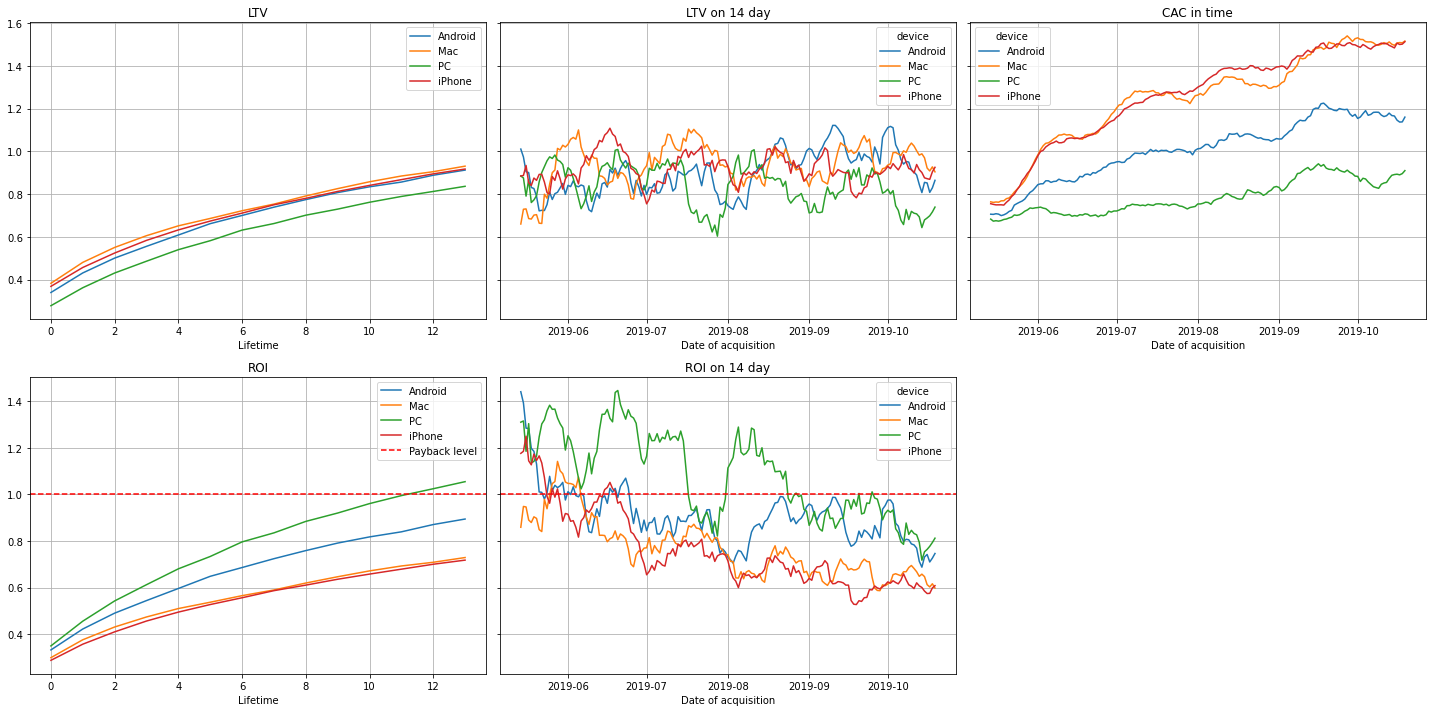

In [104]:
# have a deeper view across devices

dimensions = ['device']

# get LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# plot LTV, ROI, and CAC
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

- With the help of breakdown by devices, we see that the **advertising is paying back only for PC**
- All other devices are from the profitablity, especially **Mac and iPhone**
- LTV on the last day of analysis horizon is pretty stable across time and devices
- However, CAC grew significantly in time for **Mac and iPhone**, and in lesser extent for Android and PC, which influenced the ROI negatively

## Retention and conversion

### Devices

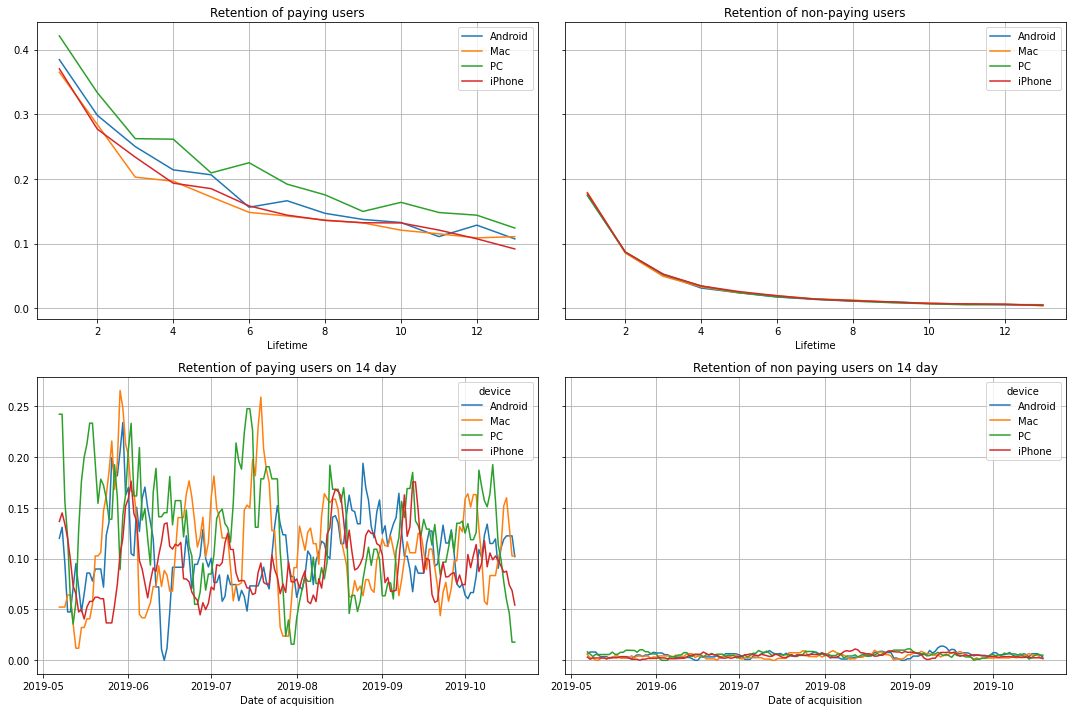

In [107]:
dimensions = ['device']

# get retentions
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Retention by devices look pretty good and the same
- PC has the the highest rates of retention
- At the same time, PC had the biggest swings in retention on the last day of analysis across time 

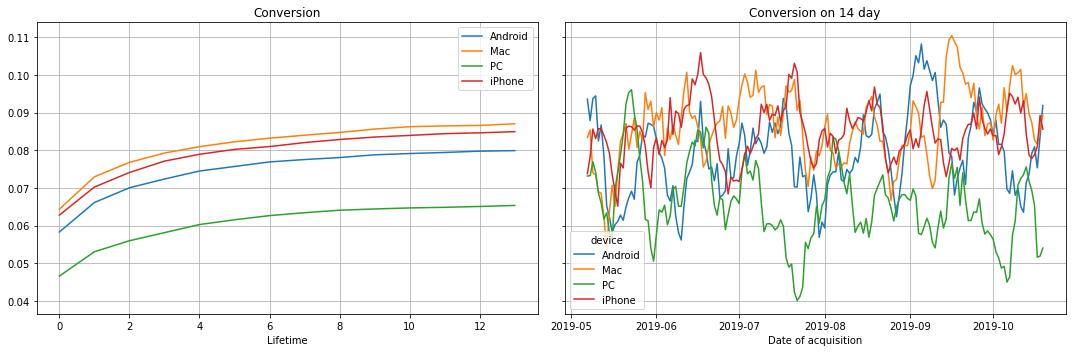

In [108]:
# get conversion and plot

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

- As for the conversion by device, it is the opposite: PC has the lowest conversion, while **Mac has the highest**
- Conversion on the last day of analysis horizon across time for each device show a lot of instability

### Countries

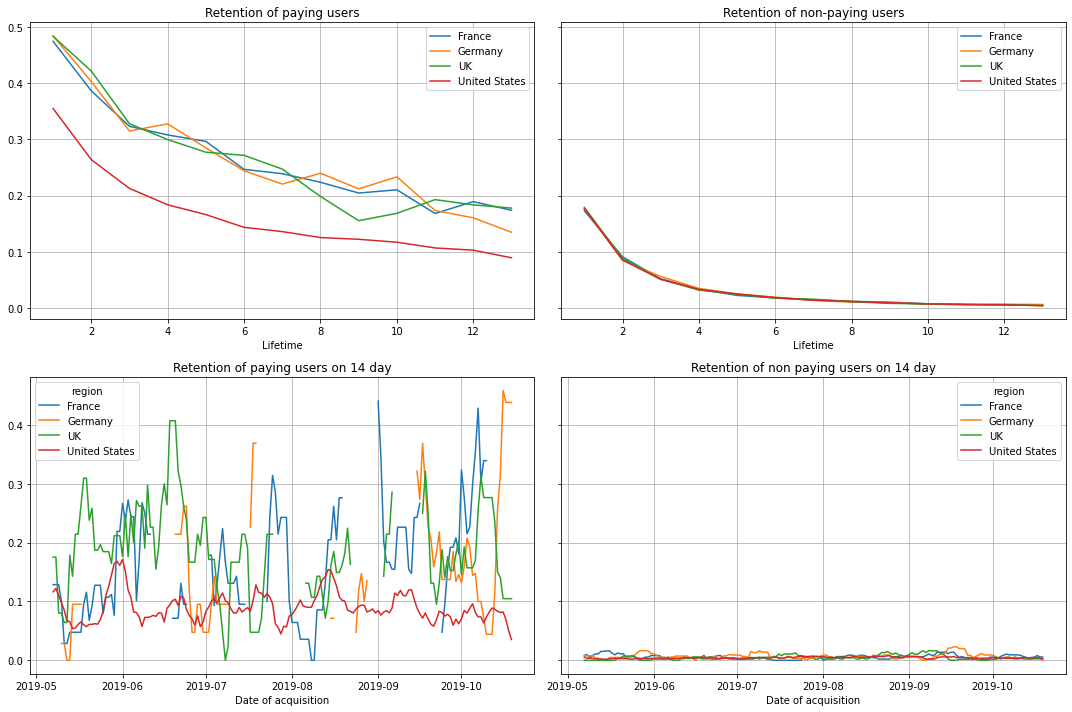

In [109]:
dimensions = ['region']

# get retentions
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Across countries, again **the US shows the weakest data on reteining paying users** compared to other countries
- Although over time it was pretty stable, while **other countries show a lot of variability of retention** of paying users on the last day of analysis horizon
- Retention of non payers is the same for all countries

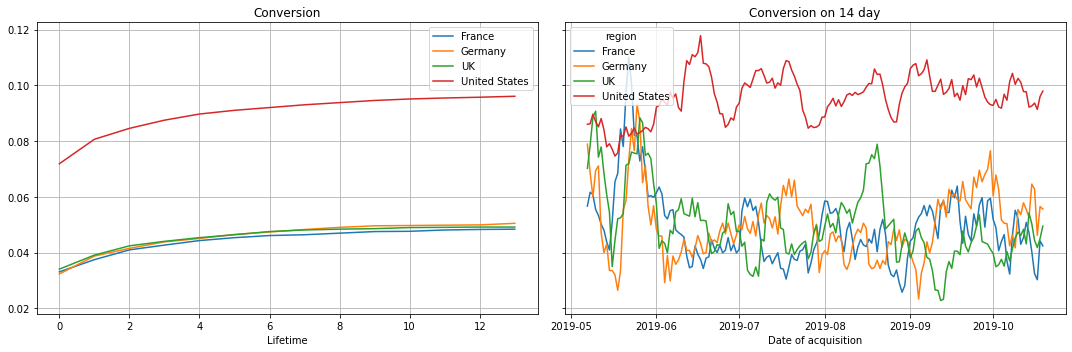

In [110]:
# get conversion and plot

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

- As for the conversion by country, it is the opposite: **US has the highest conversions**
- Conversion on the last day of analysis horizon across time for the US went high in May and continued to stay elevated, which recalls overall LTV curve

### Channels

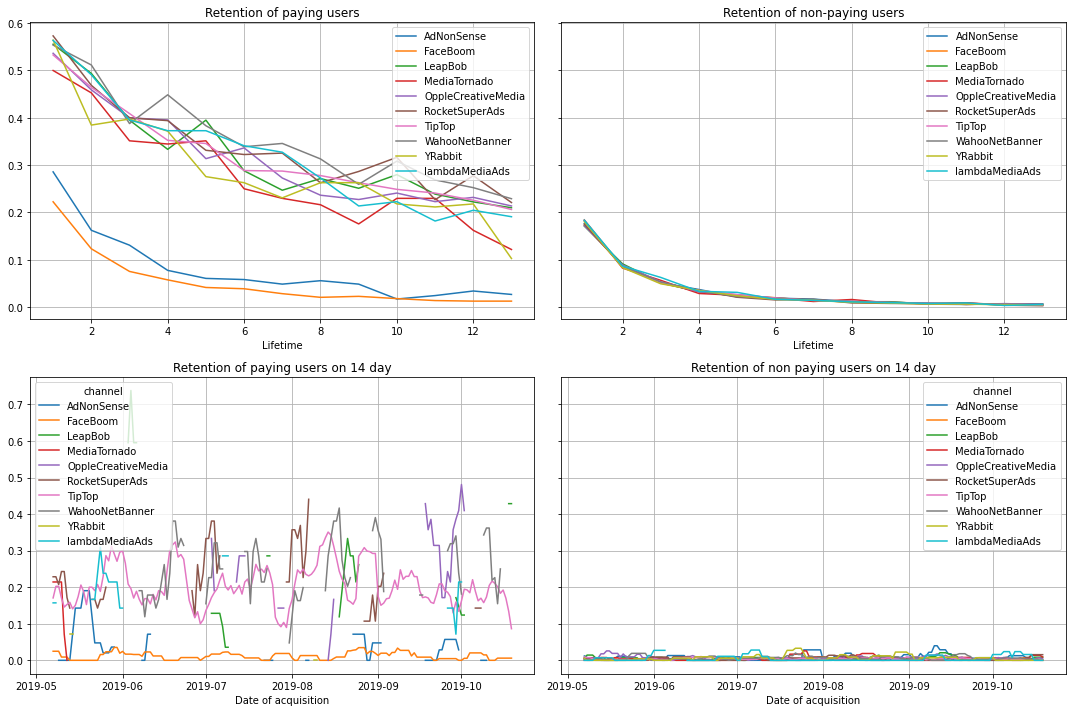

In [111]:
dimensions = ['channel']

# get retentions
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Retention across platforms is pretty stable except for **FaceBoom and AdNonSense**, that have significantly lower retentions
- Over time, there is a lot of noise

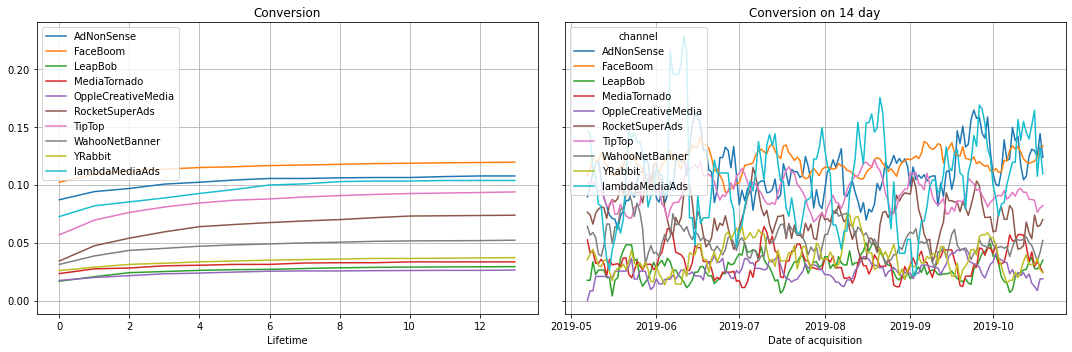

In [112]:
# get conversion and plot

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

- As for the conversion by platform, it is the opposite: **FaceBoom and AdNonSense have the highest rates**
- Conversion on the last day of analysis horizon across time shows a lot of variability

We try check our findings from the points above by filtering out the worst channels and countries.

### Total without US

In [113]:
profiles_no_us = profiles.query('region != "United States"')

# get LTV and ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_us, orders, observation_date, horizon_days
)

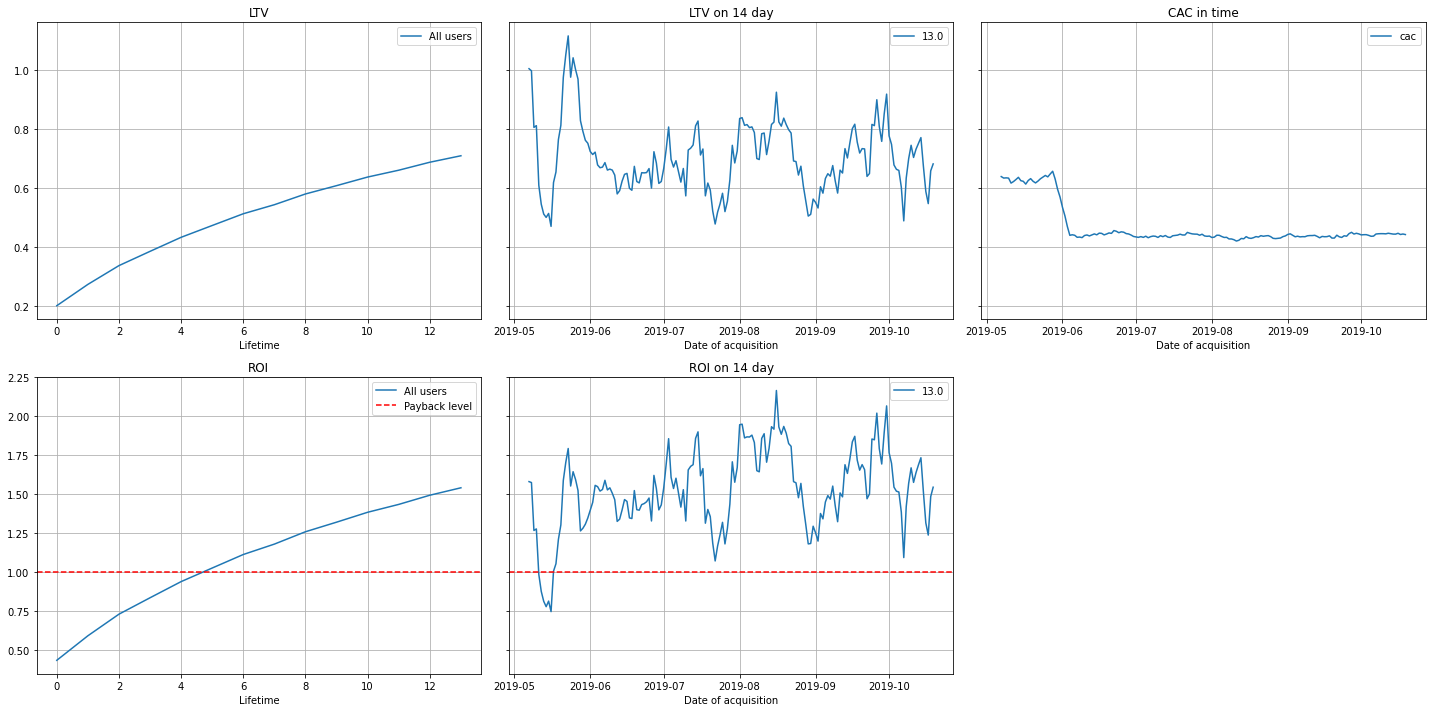

In [114]:
# plot LTV, ROI, and CAC

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [115]:
(profiles['region']=="United States").sum() / profiles['region'].count()

0.6607850890786479

- Due to pretty stable LTV (although with some variablility) falling CAC and in other countries excluding US, **ROI looks great**
- The pay back is happening **on the 6th day**
- However, it is not very smart just to kill the whole business in the US as **there are 2/3 of all our non-organic users**

### Total without TipTop platform

In [116]:
profiles_no_tiptop = profiles.query('channel != "TipTop"')

# get LTV and ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop, orders, observation_date, horizon_days
)

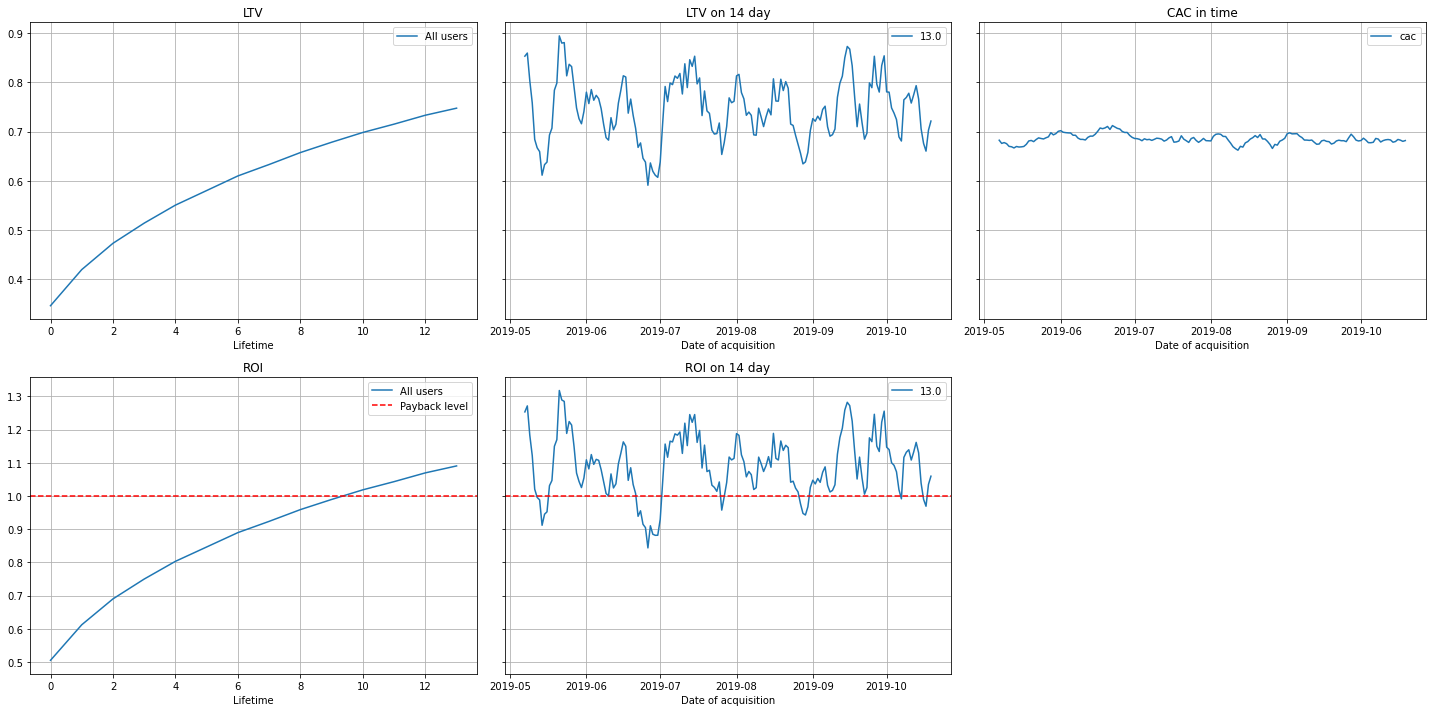

In [117]:
# plot LTV, ROI, and CAC

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

In [118]:
(profiles['channel']=="TipTop").sum() / profiles['channel'].count()

0.20905428079812757

- Without TipTop channel, the **advertising is paying back**
- The pay back is happening **on the 10th day**
- Without TipTop the CAC is very stable across time
- It would be wise to stop advertising on TipTop as **there are only 20% of all our non-organic users**

We drill further down by killing one more non profitable platform.

### Total without TipTop and FaceBoom platforms

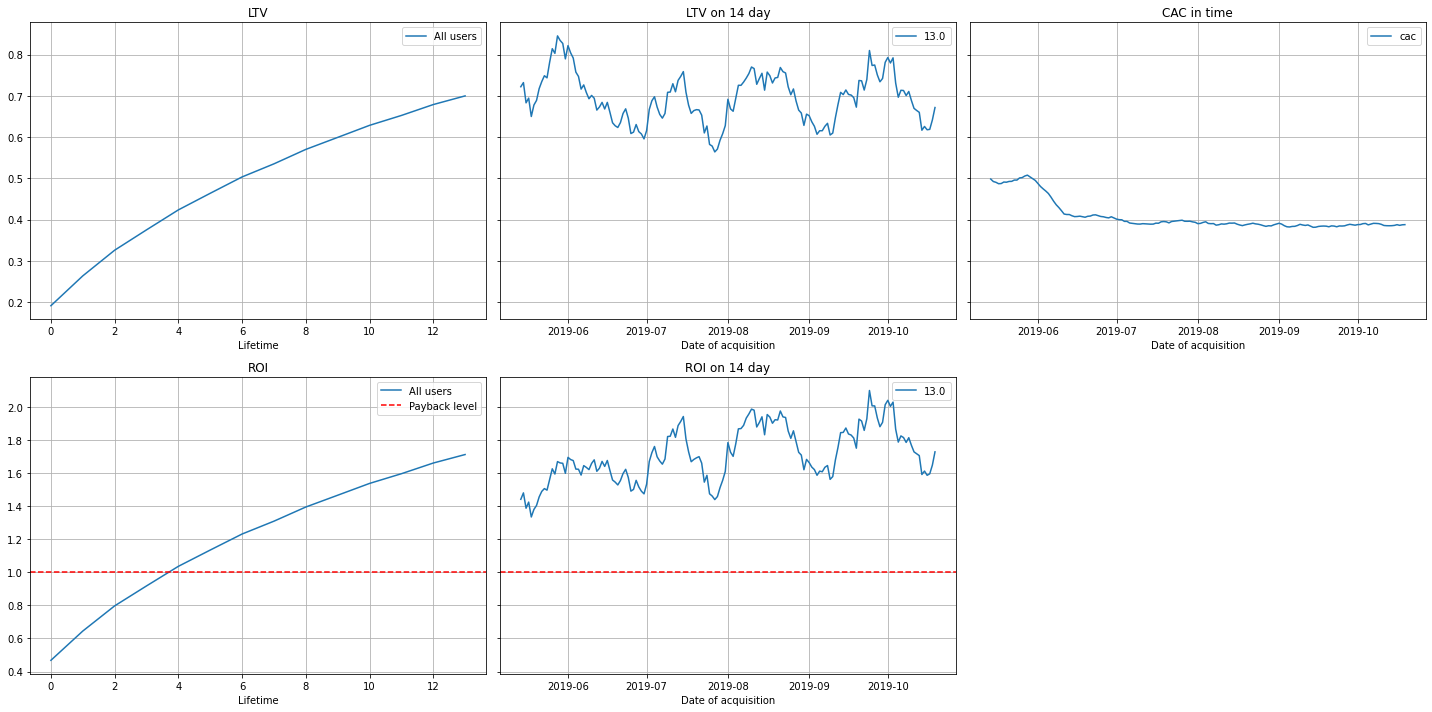

In [119]:
profiles_no_tiptop_no_faceboom = profiles_no_tiptop.query('channel!="FaceBoom"')

# get LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop_no_faceboom, orders, observation_date, horizon_days
)

# plot LTV, ROI, and CAC
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

In [120]:
profiles_no_tiptop_no_faceboom['user_id'].count() / profiles['user_id'].count()

0.47947503981019357

- Without TipTop and FaceBoom channels, **the advertising is paying back big and fast**
- The pay back is happening **on the 5th day already** and on 14th day ROI is around 1,7 = big returns
- On all other platforms the CAC is going downwards
- LTV and thus ROI show stability with some seasonality
- By "killing" these two platforms we lose around 52% of all our non-organic users

We drill further down by killing one more non profitable platform.

### Total without TipTop, FaceBoom, and AdNonSense platforms

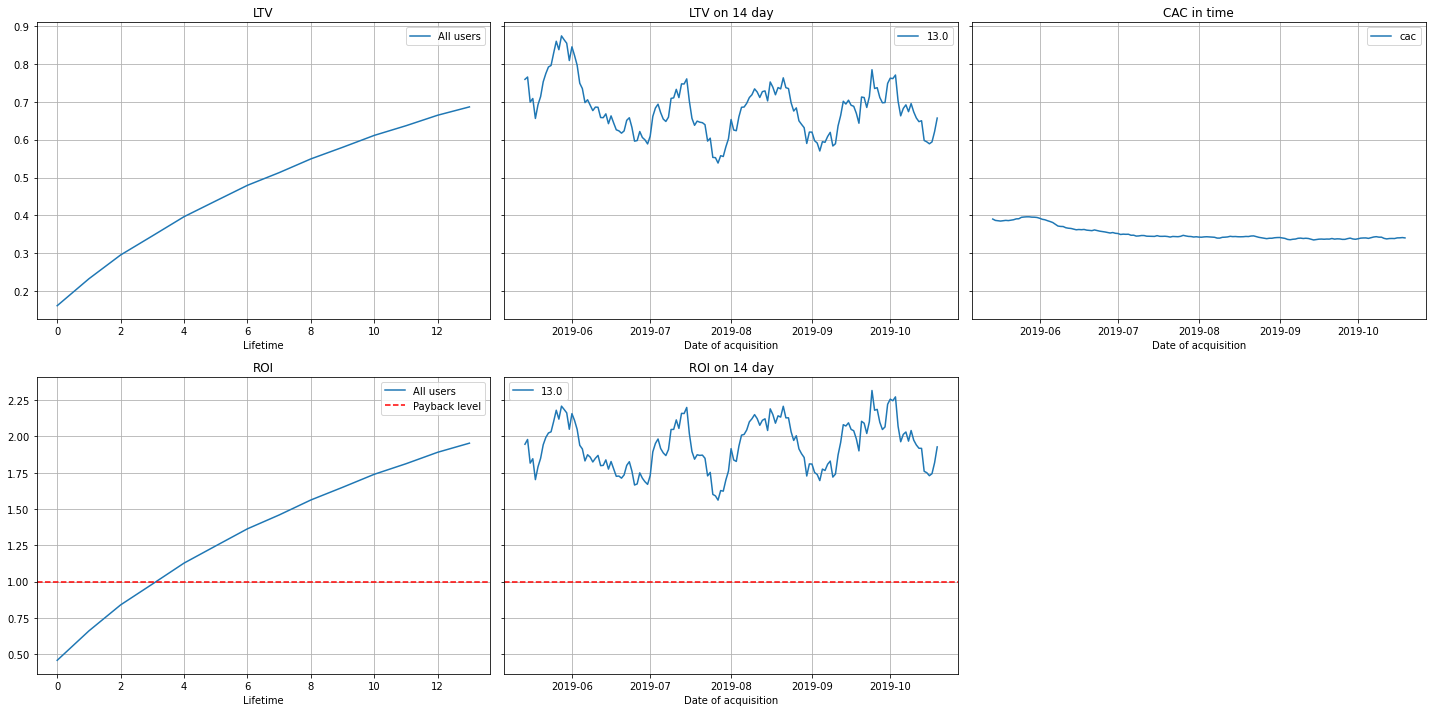

In [121]:
profiles_no_tiptop_no_faceboom_no_adnonsense = profiles_no_tiptop_no_faceboom.query('channel!="AdNonSense"')

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop_no_faceboom_no_adnonsense, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

In [122]:
profiles_no_tiptop_no_faceboom_no_adnonsense['user_id'].count() / profiles['user_id'].count()

0.43800831471961865

* Killing out the last unprofitable channel, the advertising is paying back even **faster and bigger**
* The pay back is happening already **on the 4th day** and on 14th day ROI is around 2
* By cutting advertising on these 3 platforms, we lose around 56% of all our non-organic users, but **improve financials significantly**

### Profitability without 3 platforms by dimensions

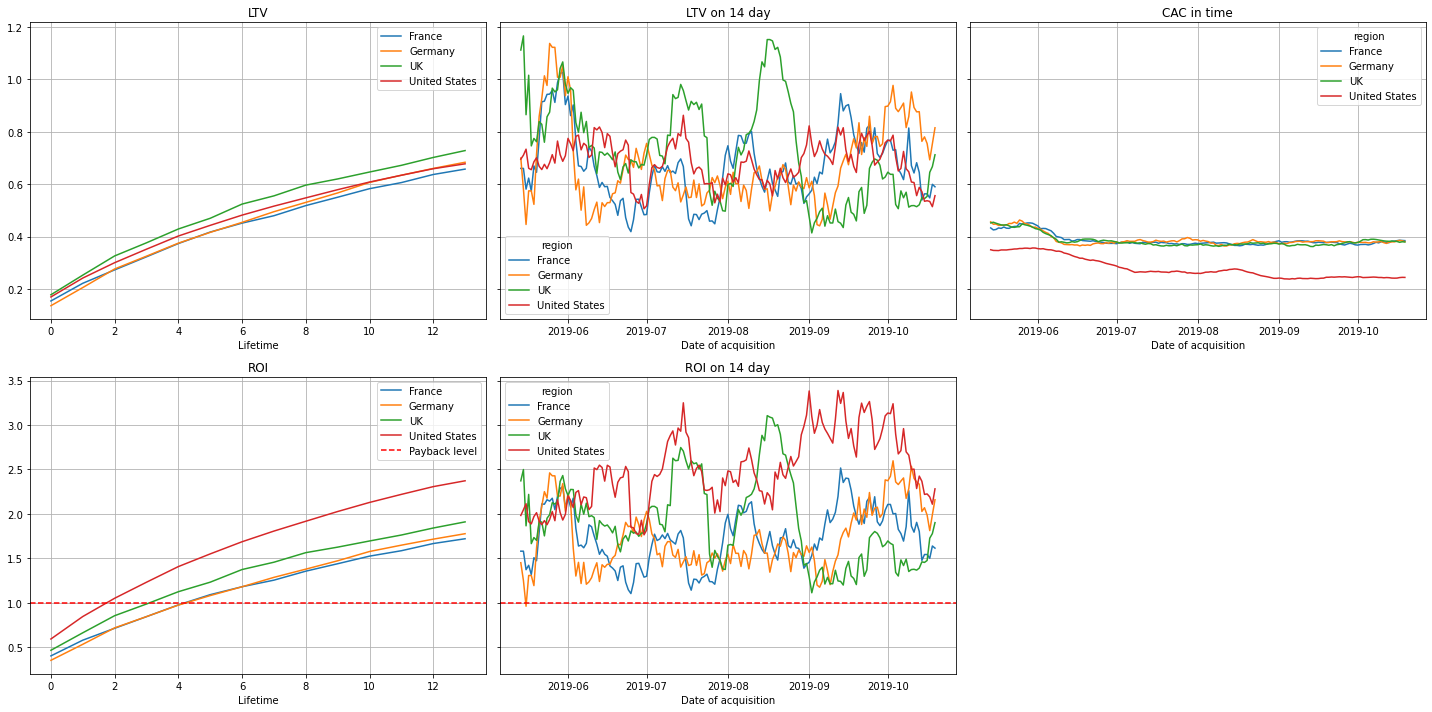

In [123]:
dimensions=['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop_no_faceboom_no_adnonsense, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

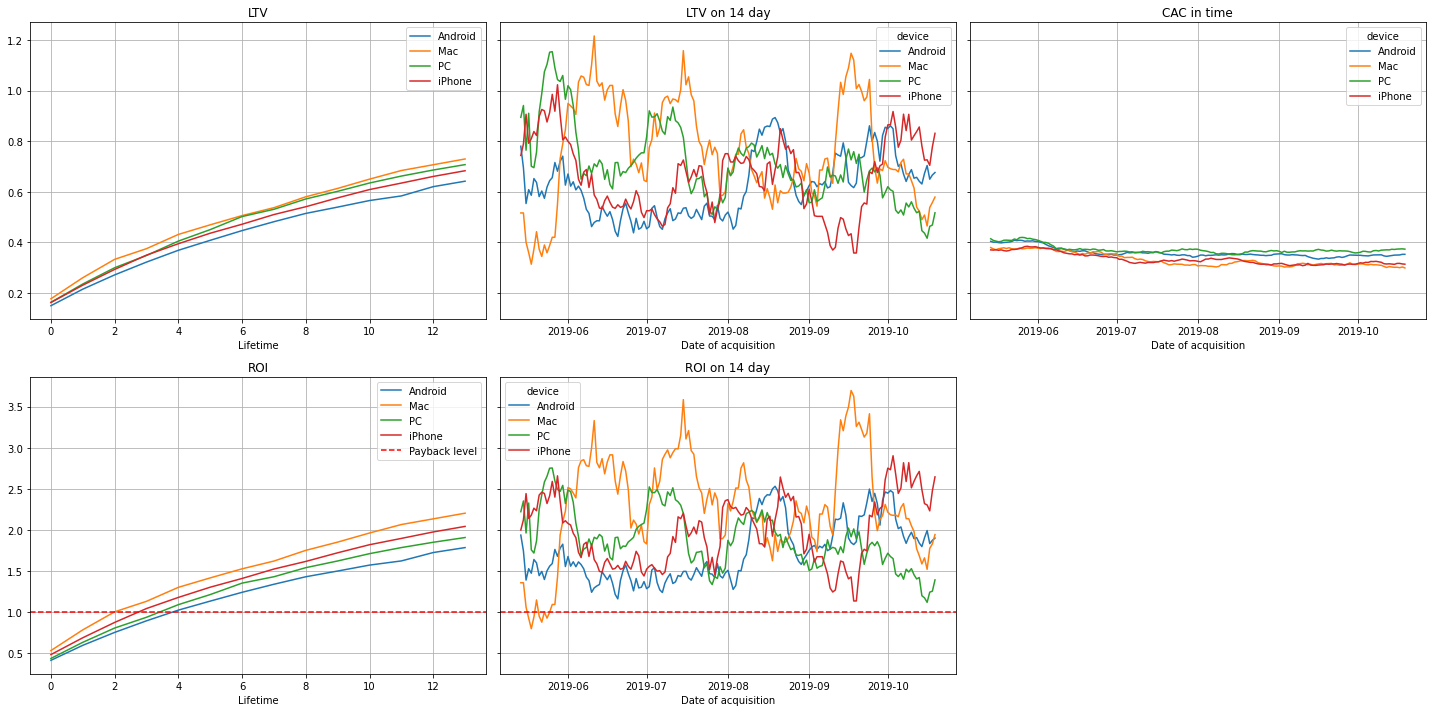

In [124]:
dimensions=['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop_no_faceboom_no_adnonsense, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

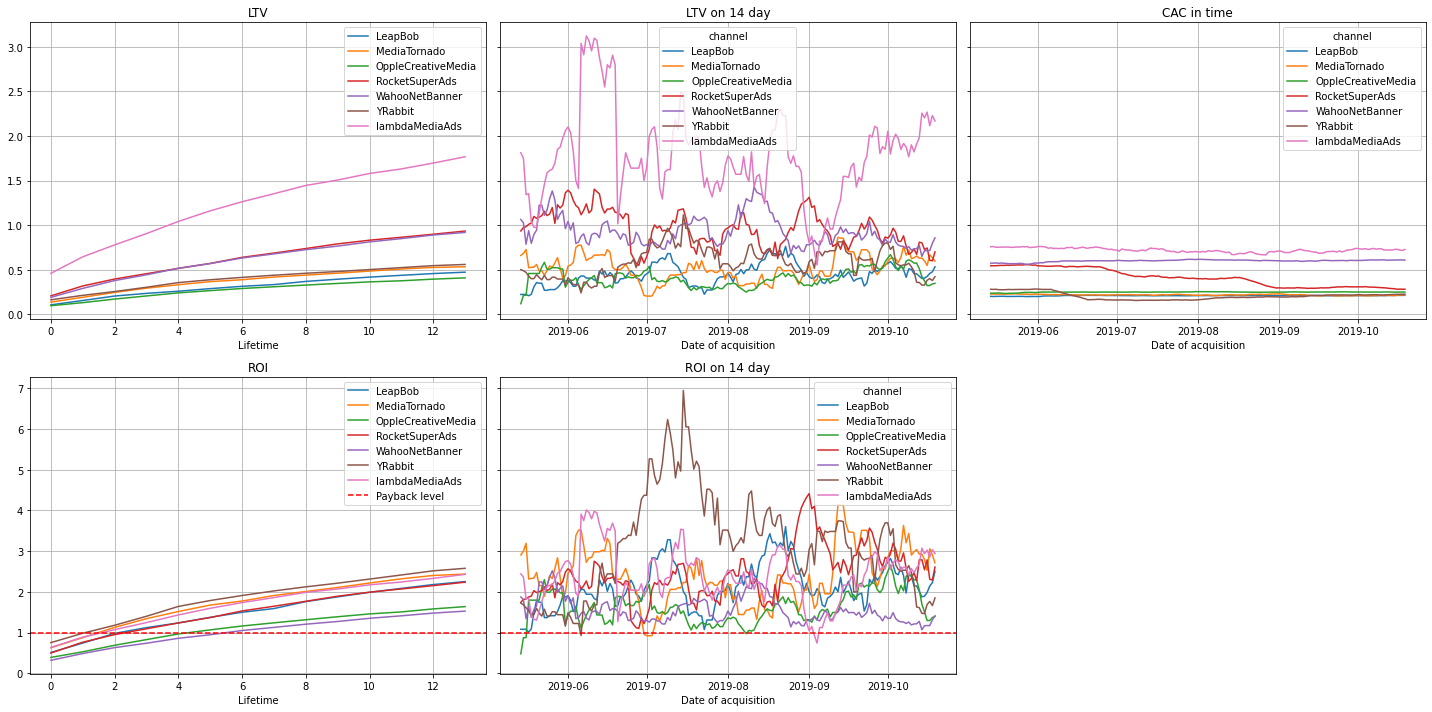

In [125]:
dimensions=['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_tiptop_no_faceboom_no_adnonsense, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

By looking at the payback without three unprofitable platforms (TipTop, FaceBoom and AdNonSense), we spot that:  

- In the context of countries, **advertising in the US is even the most profitable due to the lowest CAC there**; advertising in other countries is just as profitable and pays off quickly
- Out of european countries, UK is standing out - metrics there are slightly higher than in Germany and France
  
  
- By device, **advertising pays off everywhere**, although there is a large variability in LTV on all devices
  
  
- In the context of the platform, **YRabbit turns out to be the most profitable**, although there is a strong seasonality for users who joined in July

We drill further down by splitting the users by regions.

### Profitablity without 3 platforms in the US

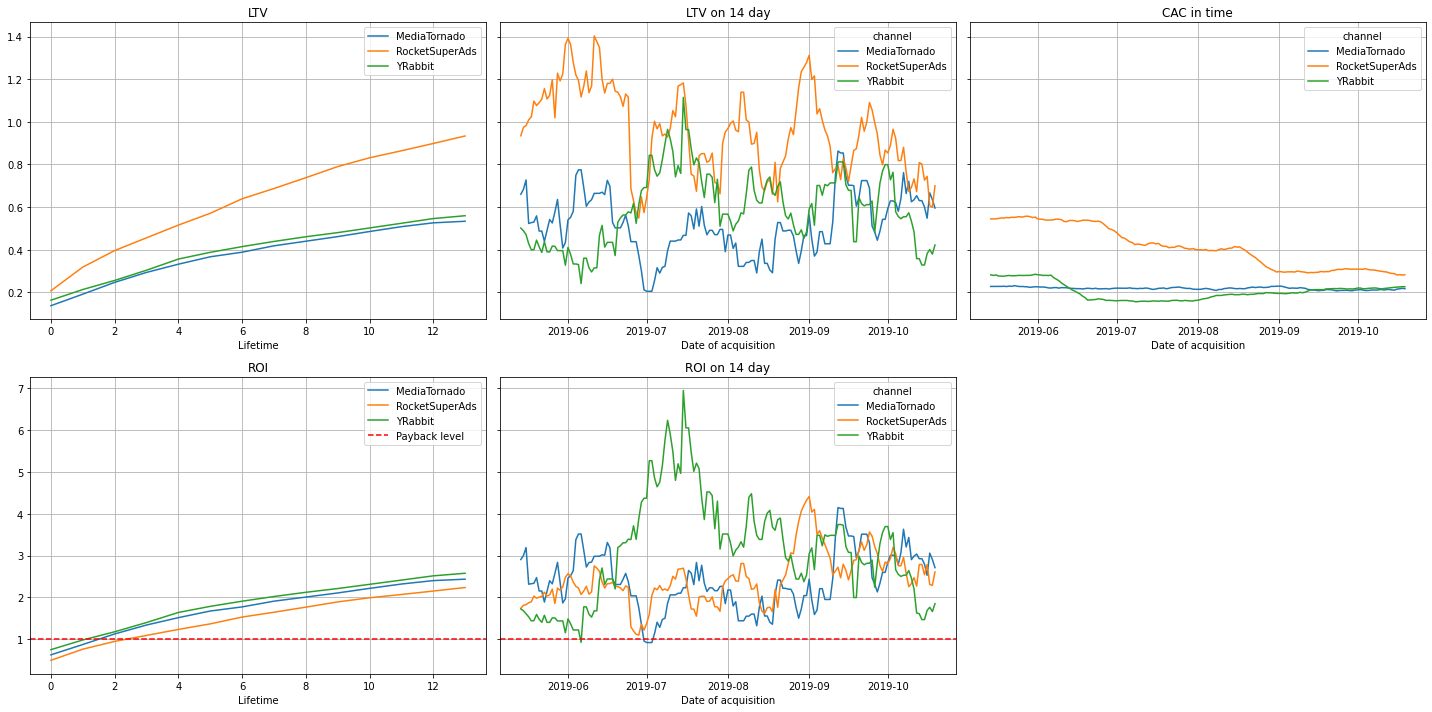

In [126]:
profiles_us = profiles_no_tiptop_no_faceboom_no_adnonsense.query('region=="United States"')

dimensions=['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

* In the USA, as well as in all countries above, **YRabbit** is the most profitable platform due to the low CAC
* Also **there is a great downward trend in CAC on the RocketSuperAds platform**, despite the fact that it generates the highest LTV = it would be wise to continue to observe the dynamics of CAC, as it has a chance to become very profitable

### Profitablity without 3 platforms in Europe

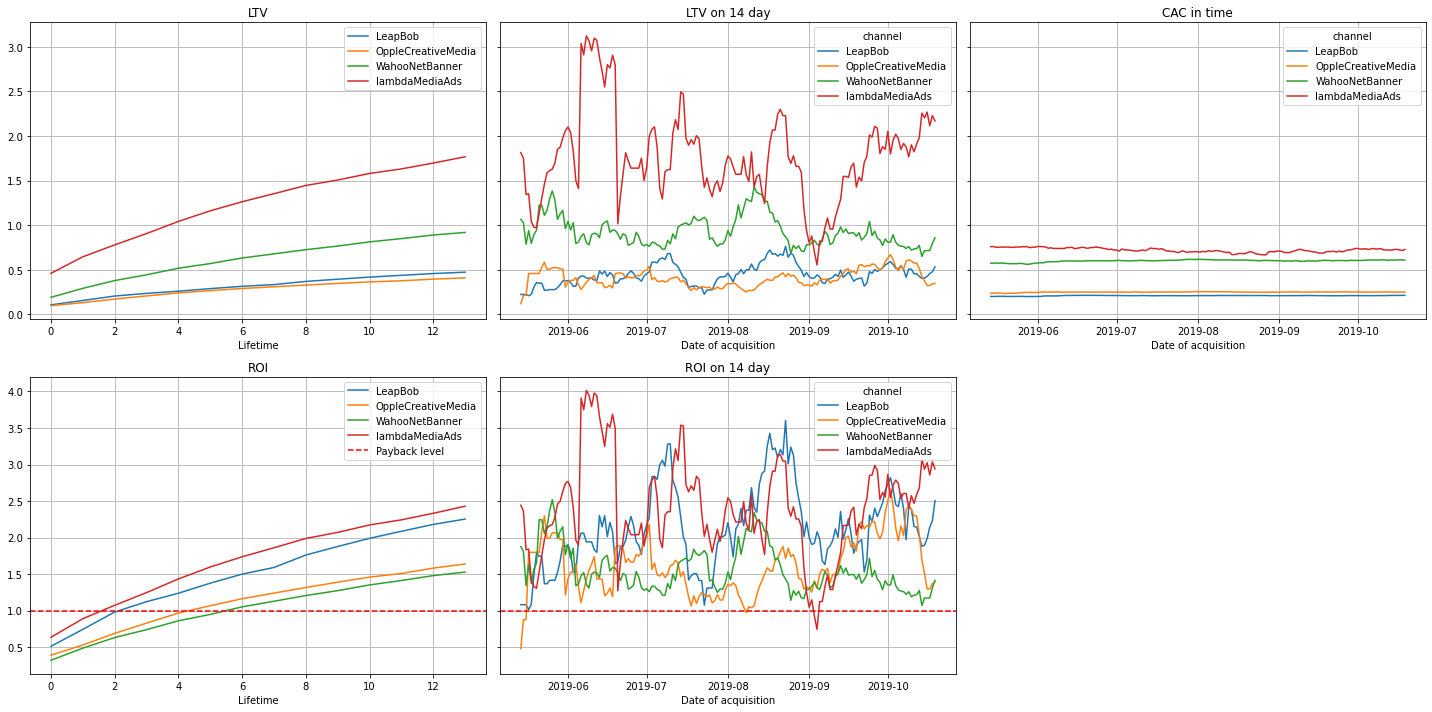

In [127]:
profiles_europe = profiles_no_tiptop_no_faceboom_no_adnonsense.query('region!="United States"')

dimensions=['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_europe, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

* In Europe, **the most profitable platform is lambdaMediaAds**, even though it has the highest CAC
* Also **need to keep an eye on the LeapBob platform** as it has great potential

## Results

* We had data for new users who registered in the period from 2019-05-01 to 2019-10-27
* Our observation date was 2019-11-01 and analysis horizon 14 days
* In this period there were a bit more than 150k unique users
  
  
* The highest number of **unique users are coming from the US (around 2/3)**
* The **US has also the highest portion of paying users** - around 7%
* Most of the unique users are using **iPhone**, while among the **Mac** users - the highest proportion of paying ones
* The highest proportions of paying users are coming from **FaceBoom, AdNonSense, and lambdaMediaAds** channels: around 12%, 11%, and 10%, respectively
* Organic source, not surprisingly, has the lowest proportion of payers with **a bit more than 2%**
  
    
* Total marketing costs in the period of analysis were 105497
* Costs across channels were not distributed uniformly: two channels - **TipTop and FaceBoom** - got the biggest portions of total marketing costs (52% and 31%, respectively)
  
  
* Overall, the advertising in the period of analysis was **not paying back within 14 days horizon**
* This is **due to skyrocketed CACs over time** (as LTV was pretty stable = over time going up and down within the channel)
* The advertising on **TipTop, FaceBoom, and AdNonSense platforms were not profitable**
* Across countries, the **United States had the biggest downward pressure on ROI** and didn't reach a profit
* **FaceBoom and AdNonSense platforms** have significantly low retentions while having the highest conversion rates


## Recommendation to the marketing team

* We did some filtering out different regions and channels and came to the conclusion that it would be appropriate to stop advertising on **TipTop, FaceBoom, and AdNonSense** platforms
* By "killing" these two platforms we **lose around 56% of all our non-organic users**, but improve the marketing financials significantly
* In such a case, the pay back is happening on the **4th day already**
* On the 14th day the ROI is **around 2** 
* Moreover, that would **save up to 87% of marketing costs**

When we look at the payback without three unprofitable platforms (TipTop, FaceBoom, and AdNonSense), we see that:

* In terms of countries, advertising in the USA even turns out to be the most profitable due to the lowest CAC; advertising in other countries is just as profitable and pays off quickly
* Of the European countries, the United Kingdom stands out - there the figures are slightly higher than in Germany and France
* In terms of devices, advertising pays off everywhere, although there is a large variability in LTV on all devices
  
  
* In terms of platforms, in the USA **YRabbit** is the most profitable platform due to lowest CAC
* Also **there is a great downward trend in CAC on the RocketSuperAds platform** in the US, despite the fact that it generates the highest LTV = should be further observed in the dynamics of CAC, as it has the chance to become very profitable
* In Europe, the most profitable platform is **lambdaMediaAds**, even though it has the highest CAC
* We also need to keep an eye on the **LeapBob platform** as it has great potential